# This is the Fine-Tuning for Text Classification simple example
# Part 3: Converting binary DeBerta to multi-class classification
#         using the data sets from Cyberbullying
- https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

# NOTE: I need to review the Huggingface set of documentations and videos
#       example is: https://huggingface.co/docs/transformers/training 

In [ ]:
# put drive connection code if needed
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Github/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github


In [ ]:
!git config --global user.email "bgoldfe2@gmu.edu"
!git config --global user.name "Bruce Goldfeder"

!cp -R ssh/ ~/.ssh
!ls -alh ~/.ssh

total 20K
drwx------ 2 root root 4.0K Feb 25 20:15 .
drwx------ 1 root root 4.0K Feb 25 20:15 ..
-rw------- 1 root root 3.2K Feb 25 20:15 id_rsa
-rw------- 1 root root  742 Feb 25 20:15 id_rsa.pub


In [ ]:
# Code to install the nightly version if needed for debugging

#!nvcc --version
#!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu117

In [ ]:
!pip install transformers
# Helps when using fast tokenizers
!pip install sentencepiece

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
import math

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pwd
%cd dissertation-ground-up-version/Dataset/

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/dissertation-ground-up-version/Dataset


In [ ]:
%cd SixClass/
!head -10 train.csv

In [ ]:
df = pd.read_csv("train.csv")

# First 5 rows
display(df.head())
df2 = df[['label', 'target']]
df3 = (df2.drop_duplicates()).sort_values('target')
print(tabulate(df3, headers='keys', tablefmt='github', showindex=False))

,Unnamed: 0,text,label,target
0,38746,#trumprussia sean spicer is a blithering idiot...,Others,4
1,47265,If you call yourself a Christian yet you suppo...,Religion,5
2,36632,Small red lights in dark rooms.,Others,4
3,29064,If u find yourself pouting that no male report...,Notcb,3
4,33884,Messi carried these retards to three consecuti...,Others,4


| label     |   target |
|-----------|----------|
| Age       |        0 |
| Ethnicity |        1 |
| Gender    |        2 |
| Notcb     |        3 |
| Others    |        4 |
| Religion  |        5 |


In [ ]:
df.drop(df.columns[[0, 2]], axis=1, inplace=True)
df.rename(columns = {'target':'label'}, inplace = True)
display(df.head())

,text,label
0,#trumprussia sean spicer is a blithering idiot...,4
1,If you call yourself a Christian yet you suppo...,5
2,Small red lights in dark rooms.,4
3,If u find yourself pouting that no male report...,3
4,Messi carried these retards to three consecuti...,4


<AxesSubplot:xlabel='label'>

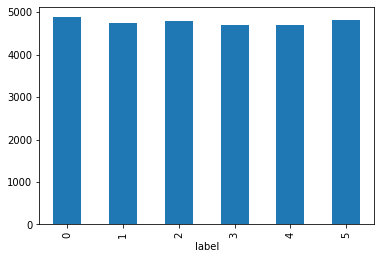

In [ ]:
df.groupby(['label']).size().plot.bar()

# Need to implement custom Dataset as in https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [ ]:
model_nm = 'microsoft/deberta-v3-small'

tokenizer = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(type(tokenizer))

<class 'transformers.models.deberta_v2.tokenization_deberta_v2_fast.DebertaV2TokenizerFast'>


In [ ]:
# Create lists of texts and labels
text = df.text.values
labels = df.label.values

def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒════════════╤═════════════╕
│ Tokens     │   Token IDs │
╞════════════╪═════════════╡
│ ▁there     │         343 │
├────────────┼─────────────┤
│ s          │         268 │
├────────────┼─────────────┤
│ ▁this      │         291 │
├────────────┼─────────────┤
│ ▁person    │         604 │
├────────────┼─────────────┤
│ ▁that      │         272 │
├────────────┼─────────────┤
│ ▁used      │         427 │
├────────────┼─────────────┤
│ ▁to        │         264 │
├────────────┼─────────────┤
│ ▁bully     │       21319 │
├────────────┼─────────────┤
│ ▁me        │         351 │
├────────────┼─────────────┤
│ ▁in        │         267 │
├────────────┼─────────────┤
│ ▁school    │         563 │
├────────────┼─────────────┤
│ ▁and       │         263 │
├────────────┼─────────────┤
│ ▁now       │         394 │
├────────────┼─────────────┤
│ ▁they      │         306 │
├────────────┼─────────────┤
│ ve         │         415 │
├────────────┼─────────────┤
│ ▁had       │         330 │
├────────────┼

In [ ]:
labels = {'Age':0,
          'Ethnicity':1,
          'Gender':2,
          'Notcb':3,
          'Others':4,
          'Religion' :5
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 128, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
token_id[6]

tensor([    1,  1715,   280,   268,   831,   664,   265,   262,   485,   920,
         2921,   260,   336,   540,   277,  5292,   277, 88953,   260,  5372,
         2071,  2340,   281,   307, 45008,  5415,   355,   309,   277,   262,
          423,   260,  2135,  1519,   260,   260,   260,   724,  1863,  3103,
          267,   262,   697,   696,  2591,   266,  2132,  1220,   263,  2560,
         1471,  3790,  3930,   260,  6359,   363,   300,   300,   300,   300,
          300,   300,   300,   300,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │           1 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁@          │        1944 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ S           │         430 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ iraj        │      106791 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ Z           │        3206 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ aroo        │       48281 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ k           │        1165 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁@          │        1944 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ Bil         │       88971 │                1 │
├─────────────┼─────

In [ ]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 32

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [ ]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
# Load the SequenceClassification model
model = AutoModelForSequenceClassification.from_pretrained(
    model_nm,
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        #print(b_labels)
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


cuda


Epoch:  50%|█████     | 1/2 [02:15<02:15, 135.63s/it]


	 - Train loss: 0.5647
	 - Validation Accuracy: 0.3294
	 - Validation Precision: 0.9692
	 - Validation Recall: 0.9668
	 - Validation Specificity: 0.9790



Epoch: 100%|██████████| 2/2 [04:28<00:00, 134.34s/it]


	 - Train loss: 0.3542
	 - Validation Accuracy: 0.3282
	 - Validation Precision: 0.9848
	 - Validation Recall: 0.9860
	 - Validation Specificity: 0.9894



In [ ]:
#new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'
new_sentence = 'You are an ugly girl'
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

#prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'
prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  You are an ugly girl
Predicted Class:  3


In [ ]:
len(test_ids[0])

32

In [ ]:
encoding

{'input_ids': tensor([[    1, 67991,   300,   300,   463,   266,  6119,  1191,  1099,   274,
           286,   331,  2068,   264,  1069,   452, 28427,   962,  4597,  5505,
           300,   502,  1674,   660,  7993, 60489, 39908, 45500,   260, 21049,
          1197,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
output.logits.cpu().numpy()

array([[-2.6940677,  2.7711425]], dtype=float32)

In [ ]:
type(np.argmax(output.logits.cpu().numpy()))

numpy.int64

In [ ]:
np.argmax(output.logits.cpu().numpy()).flatten()

array([1])

In [ ]:
np.argmax(output.logits.cpu().numpy()).flatten().item()

1

In [ ]:
type(np.argmax(output.logits.cpu().numpy()).flatten().item())

int